# Calculate the sigmoid functions
## Libraries

In [112]:
from pandas import DataFrame, read_csv
import datetime
import math
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import pylab
from scipy.optimize import curve_fit
import os

In [113]:
working_directory ='/Users/peter/python/pyBuurtwarmte'
os.chdir(working_directory)

In [114]:
# read the allocation data
file = "EvO_Gas_Allocation_2017.csv"
EvO_gas_alloc = pd.read_csv(file, index_col=False, header=None);
EvO_gas_alloc.columns = ['Date', 'Allocation']
EvO_gas_alloc['Date'] = EvO_gas_alloc['Date'].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y'))
EvO_gas_alloc.set_index('Date', inplace=True)

In [115]:
# read the effective temperature data
# parse the column Date - otherwise Bokeh cannot read the data more info here
# https://stackoverflow.com/questions/54021664/bokeh-columndatasource-line-not-rendering?answertab=votes#tab-top
file = "KNMI_Teff_1965_2018.csv"
KNMI_Teff = pd.read_csv(file, index_col='Date', header=0, parse_dates=["Date"])

In [116]:
# copy only year 2017 into new data frame
KNMI_Teff_2017 = KNMI_Teff.loc['2017-01-01':'2017-12-31']

In [117]:
# add new column with 2017 effective temperature data to allocation data table
EvO_gas_alloc['Teff_lag'] = KNMI_Teff_2017['Teff_lag']

In [118]:
# read the customer number data for 2017
file = "EvO_Gas_Customer_2017.csv"
EvO_gas_customers = pd.read_csv(file, index_col=False, header=None);
EvO_gas_customers.columns = ['Date', 'Customers']
EvO_gas_customers['Date'] = EvO_gas_customers['Date'].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y'))
EvO_gas_customers.set_index('Date', inplace=True)

In [119]:
EvO_gas_customers

,Customers
Date,
2017-01-01,3015
2017-02-01,3057
2017-03-01,3114
2017-04-01,3178
2017-05-01,3293
2017-06-01,3366
2017-07-01,3417
2017-08-01,3480
2017-09-01,3514


In [120]:
for i in EvO_gas_alloc.index:
    
    month_nr = i.month
    customer_nr = 0
    for j in EvO_gas_customers.index:
        if j.month == 1:
            base_customer_nr = EvO_gas_customers.loc[j, 'Customers']
        if j.month == month_nr:
            customer_nr =  EvO_gas_customers.loc[j, 'Customers']
    
    EvO_gas_alloc.loc[i, 'Allocation_corr'] = base_customer_nr / customer_nr * EvO_gas_alloc.loc[i, 'Allocation']

In [121]:
Total_gas_corr =  EvO_gas_alloc['Allocation_corr'].sum()

base_customer_nr = EvO_gas_customers.loc['2017-01-01'].at['Customers']

print(Total_gas_corr, base_customer_nr)

5008894.58437853 3015


In [122]:
EvO_gas_alloc['Allocation_spec'] = EvO_gas_alloc['Allocation_corr'] \
                                    * (1 / (Total_gas_corr) )

In [123]:
EvO_gas_alloc.reset_index(inplace=True)

In [124]:
EvO_gas_alloc['Day'] = EvO_gas_alloc.Date.dt.day
EvO_gas_alloc['Month'] = EvO_gas_alloc.Date.dt.month
EvO_gas_alloc['Year'] = EvO_gas_alloc.Date.dt.year

In [125]:
EvO_gas_alloc.groupby(["Year"])["Allocation_spec"].sum()

Year
2017    1.0
Name: Allocation_spec, dtype: float64

In [126]:
#x_data = EvO_gas_alloc['Teff_lag'].tolist()
#y_data = EvO_gas_alloc['Allocation_400_1200'].tolist()
x_data = EvO_gas_alloc['Teff_lag']
y_data = EvO_gas_alloc['Allocation_spec']

In [127]:
def fsigmoid(T, a, b, c, d):
     y = a / (1 + (b/(T-40)) ** c) + d
     return y

In [128]:
popt, pcov = curve_fit(fsigmoid, x_data, y_data, bounds=([ 0., -41., 0., 0],[np.inf, -35., np.inf, np.inf]))

In [129]:
print(popt)

[ 1.02272607e-02 -3.90854279e+01  7.13686191e+00  2.84245267e-04]


## Sigmoid - specific demand in Nm3 / Nm3/year / day

In [ ]:
#y = fsigmoid(x, 4.11, -39.4, 7.61, 0.169)
y = fsigmoid(x, popt[0], popt[1], popt[2], popt[3])
print("Max value element : ", 1.2 * homes_demand_factor * max(y))
#print(y)
pylab.plot(x_data, y_data, 'o', label='data')
pylab.plot(x,      homes_demand_factor * 1.0 * y, label='fit avg')
pylab.plot(x,      homes_demand_factor * 0.8 * y, label='fit min')
pylab.plot(x,      homes_demand_factor * 1.2 * y, label='fit max')
pylab.xlabel('effective temperature (˚C)')
pylab.ylabel('gas demand (Nm3)')
pylab.ylim(0, 5000)
pylab.legend(loc='best')
pylab.show()

In [130]:
homes_nr = 400
demand_avg = 1200
homes_demand_factor = homes_nr * demand_avg
x = x_data

Max value element :  4579.0491283359615


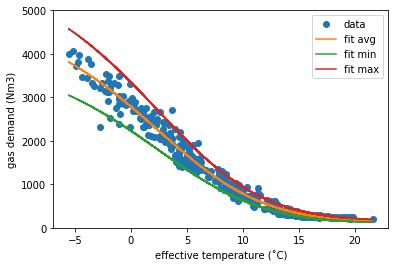

In [131]:
#y = fsigmoid(x, 4.11, -39.4, 7.61, 0.169)
y = fsigmoid(x, popt[0], popt[1], popt[2], popt[3])
print("Max value element : ", 1.2 * homes_demand_factor * max(y))
#print(y)
pylab.plot(x_data, homes_demand_factor * y_data, 'o', label='data')
pylab.plot(x,      homes_demand_factor * 1.0 * y, label='fit avg')
pylab.plot(x,      homes_demand_factor * 0.8 * y, label='fit min')
pylab.plot(x,      homes_demand_factor * 1.2 * y, label='fit max')
pylab.xlabel('effective temperature (˚C)')
pylab.ylabel('gas demand (Nm3)')
pylab.ylim(0, 5000)
pylab.legend(loc='best')
pylab.show()

In [132]:
KNMI_Teff['Gas_demand'] = homes_demand_factor * fsigmoid(KNMI_Teff['Teff_lag'], popt[0], popt[1], popt[2], popt[3])

In [133]:
KNMI_Teff['Gas_demand_specific'] = fsigmoid(KNMI_Teff['Teff_lag'], popt[0], popt[1], popt[2], popt[3])

In [134]:
list(KNMI_Teff)

['# STN',
 'YYYYMMDD',
 'FG',
 'TG',
 'Q',
 'Teff',
 'Teff_lag',
 'Gas_demand',
 'Gas_demand_specific']

In [135]:
from bokeh.models import ColumnDataSource, HoverTool, Range1d, LinearAxis
from bokeh.plotting import figure, show, output_file
from bokeh.io import show, output_notebook, show

output_notebook()

source = ColumnDataSource(KNMI_Teff)

fig = figure()

fig  = figure(x_axis_type="datetime")
# Define x-axis
#fig.xaxis.axis_type = "datetime"
fig.xaxis.axis_label = 'Date'

# Define 1st LHS y-axis
fig.yaxis.axis_label = 'Gas demand (Nm3)'
fig.y_range = Range1d(start=-0, end=5000)


fig.line(
    x='Date',
    y='Gas_demand',
    source = source,
    legend = 'gas demand (Nm3)',
    line_width = 0.5,
    color = 'grey'
)


#fig.add_tools(HoverTool(tooltips=[("Teff", "@Teff"), ("Teff_lag", "@Teff_lag")]))
fig.toolbar_location = 'above'

show(fig)

Loading BokehJS ...

In [136]:
file = "KNMI_Teff_1965_2018_spec.csv"
export_report = KNMI_Teff.to_csv(file)

In [137]:
#KNMI_Teff

In [138]:
KNMI_Teff.reset_index(inplace=True)

In [139]:
KNMI_Teff['Day'] = KNMI_Teff.Date.dt.day
KNMI_Teff['Month'] = KNMI_Teff.Date.dt.month
KNMI_Teff['Year'] = KNMI_Teff.Date.dt.year

In [140]:
#KNMI_Teff

In [141]:
KNMI_Teff.groupby(["Year"])["Gas_demand_specific"].sum()

Year
1965    1.256724
1966    1.215361
1967    1.141012
1968    1.236735
1969    1.297464
1970    1.294207
1971    1.133151
1972    1.223427
1973    1.224845
1974    1.180324
1975    1.194204
1976    1.210172
1977    1.157279
1978    1.214551
1979    1.325381
1980    1.250839
1981    1.234082
1982    1.155627
1983    1.163957
1984    1.219544
1985    1.299119
1986    1.298168
1987    1.267415
1988    1.110643
1989    1.008931
1990    0.994031
1991    1.159219
1992    1.091154
1993    1.199440
1994    1.105777
1995    1.162796
1996    1.345060
1997    1.132111
1998    1.082077
1999    1.025388
2000    1.013808
2001    1.072605
2002    1.043203
2003    1.084769
2004    1.050934
2005    1.024885
2006    1.025022
2007    0.939041
2008    1.041224
2009    1.037663
2010    1.254176
2011    1.016721
2012    1.067640
2013    1.138635
2014    0.893496
2015    0.984056
2016    1.035785
2017    1.000000
2018    0.993209
Name: Gas_demand_specific, dtype: float64